<a href="https://colab.research.google.com/github/JhonathanOrtiz/DeepCV-Pytorch/blob/master/CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requiremnts to import kaggle dataset


In [189]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Resize
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import CIFAR10


dataset = CIFAR10('data', transform=transforms.Compose([Resize((32,32)), 
                                                        ToTensor(), 
                                                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                                                        download=True)

val_len = int(len(dataset)*0.1) 
train_len = len(dataset) - val_len

train_ds, val_ds = random_split(dataset, [train_len, val_len])

test_len = int(len(val_ds)*0.1)
val_len = len(val_ds) - test_len                            

val_ds, test_ds = random_split(val_ds, [val_len, test_len]) 

print(len(train_ds), len(val_ds), len(test_ds))

Files already downloaded and verified
45000 4500 500


In [0]:
BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1179)


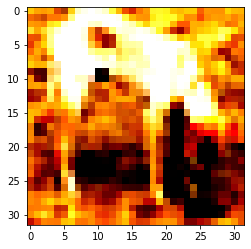

In [38]:
import matplotlib.pyplot as plt
for batch in train_loader:
  image, label = batch
  break
plt.imshow(image[0].numpy().transpose(1,2,0))

In [0]:
topology = [64, 'M', 128, 'M', 256,'M', 512, 'M', 512, 'M']

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [0]:
from torch import nn
import torch.nn.functional as F 

class Net(ImageClassificationBase):

  def __init__(self,input_channel, output_size):
    super(Net, self).__init__()
    self.input_channel =  input_channel
    self.output_size = output_size
    self.convlayer = self.create_conv_layer(topology)
    self.fc = nn.Sequential(
        nn.Linear(512*1*1, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, output_size)
    )
    
  def create_conv_layer(self, architecture):
    layers = []
    input_channel = self.input_channel

    for x in architecture:

      if type(x) == int:
        output_channel = x
        layers += [nn.Conv2d(input_channel, x, (3,3), 1, 1),
                   nn.BatchNorm2d(x),
                   nn.LeakyReLU()]
        
        input_channel = x 

      elif x == 'M':
        layers += [nn.MaxPool2d((2,2), (2,2))]     

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.convlayer(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

In [0]:
import torch
import torch.nn as nn

#Create ResidualBlock

class block(ImageClassificationBase):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [0]:
class ResNet(ImageClassificationBase):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)




In [63]:
import torch
Model = Net(3, 10)
x = torch.rand(1,3,32,32)
Model.forward(x)

tensor([[-0.0190,  0.0306,  0.0203, -0.0348,  0.0123,  0.1286,  0.0404,  0.0502,
         -0.0062,  0.1255]], grad_fn=<AddmmBackward>)

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [45]:
device = get_default_device()
device

device(type='cuda')

In [0]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [142]:
model = to_device(Net(3,10), device)
hist = evaluate(model, val_loader)
hist

{'val_acc': 0.09574468433856964, 'val_loss': 2.305103302001953}

In [144]:
history_= fit(20, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4775, val_acc: 0.4430
Epoch [1], val_loss: 1.3178, val_acc: 0.5193
Epoch [2], val_loss: 1.2711, val_acc: 0.5483
Epoch [3], val_loss: 1.1006, val_acc: 0.6303
Epoch [4], val_loss: 1.0668, val_acc: 0.6407
Epoch [5], val_loss: 0.9544, val_acc: 0.6864
Epoch [6], val_loss: 0.9506, val_acc: 0.7086
Epoch [7], val_loss: 0.9412, val_acc: 0.7050
Epoch [8], val_loss: 0.9144, val_acc: 0.7221
Epoch [9], val_loss: 0.8887, val_acc: 0.7411
Epoch [10], val_loss: 0.8714, val_acc: 0.7323
Epoch [11], val_loss: 0.9147, val_acc: 0.7371
Epoch [12], val_loss: 0.8994, val_acc: 0.7380
Epoch [13], val_loss: 0.9940, val_acc: 0.7609
Epoch [14], val_loss: 0.9861, val_acc: 0.7507
Epoch [15], val_loss: 1.0204, val_acc: 0.7653
Epoch [16], val_loss: 0.9846, val_acc: 0.7668
Epoch [17], val_loss: 0.9032, val_acc: 0.7624
Epoch [18], val_loss: 0.9485, val_acc: 0.7635
Epoch [19], val_loss: 0.9977, val_acc: 0.7622


In [145]:
def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())


test()

torch.Size([4, 1000])


In [60]:
resnet = to_device(ResNet50(3, 10), device)
history = evaluate(resnet, val_loader)
history

{'val_acc': 0.09618794173002243, 'val_loss': 2.670450210571289}

In [61]:
history = fit(20, 1e-3, resnet, train_loader, val_loader)

Epoch [0], val_loss: 2.6809, val_acc: 0.2221
Epoch [1], val_loss: 2.2561, val_acc: 0.2593
Epoch [2], val_loss: 1.8444, val_acc: 0.3395
Epoch [3], val_loss: 1.6113, val_acc: 0.4125
Epoch [4], val_loss: 1.4889, val_acc: 0.4774
Epoch [5], val_loss: 1.3611, val_acc: 0.5202
Epoch [6], val_loss: 1.2178, val_acc: 0.5678
Epoch [7], val_loss: 1.1590, val_acc: 0.5969
Epoch [8], val_loss: 1.1412, val_acc: 0.5944
Epoch [9], val_loss: 1.0445, val_acc: 0.6359
Epoch [10], val_loss: 0.9918, val_acc: 0.6571
Epoch [11], val_loss: 0.9939, val_acc: 0.6598
Epoch [12], val_loss: 0.9122, val_acc: 0.6895
Epoch [13], val_loss: 0.9178, val_acc: 0.6908
Epoch [14], val_loss: 0.9383, val_acc: 0.6855
Epoch [15], val_loss: 0.8756, val_acc: 0.7128
Epoch [16], val_loss: 0.9207, val_acc: 0.7035
Epoch [17], val_loss: 0.9094, val_acc: 0.7103
Epoch [18], val_loss: 0.9023, val_acc: 0.7046
Epoch [19], val_loss: 0.9126, val_acc: 0.7130


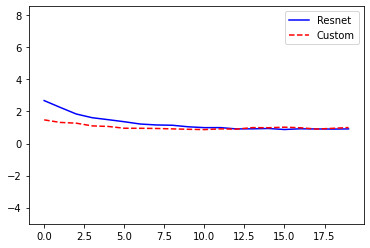

In [148]:
#Plots losses
losses_res = [x['val_loss']for x in history]
losses_cus = [x['val_loss']for x in history_]

fig, ax = plt.subplots()
ax.plot(losses_res, '-b', label='Resnet')
ax.plot(losses_cus, '--r', label='Custom')
ax.axis('equal')
leg = ax.legend()
plt.show()

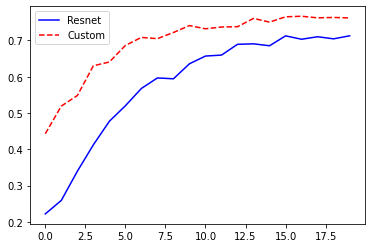

In [150]:
#Plot metrics
acc_res = [x['val_acc'] for x in history]
acc_custom = [x['val_acc'] for x in history_]

fig, ax = plt.subplots()
ax.plot(acc_res, '-b', label='Resnet')
ax.plot(acc_custom, '--r', label='Custom')
plt.legend()

In [177]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import numpy as np
for batch in test_loader:
  images, label = batch
  output = model.forward(images)
  break



x = images.cpu().data.numpy()
y_pre = output.cpu().data.numpy()
y_true = label.cpu().data.numpy()

list(y_pre)
print(label)
ypre = []

for i in y_pre:
  ypre.append(np.argmax(i))

ypre = np.array(ypre)

print(ypre.shape, y_true.shape, image.shape)

conf_m = np.array(confusion_matrix(y_true, ypre))
conf_m.shape

tensor([9, 0, 5, 5, 2, 8, 6, 0, 6, 9, 7, 1, 2, 7, 0, 2], device='cuda:0')
(16,) (16,) torch.Size([16, 3, 32, 32])


(9, 9)

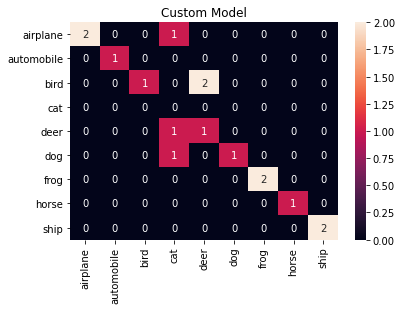

In [183]:
import pandas
import seaborn as sns

classes = [i for i in dataset.classes]
target = [i for i in dataset.classes]
df =  pd.DataFrame(conf_m, classes[:-1], target[:-1])
plt.title('Custom Model')
sns.heatmap(df, annot=True)

In [185]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import numpy as np
for batch in test_loader:
  images, label = batch
  output = resnet.forward(images)
  break

x = images.cpu().data.numpy()
y_pre = output.cpu().data.numpy()
y_true = label.cpu().data.numpy()

list(y_pre)
print(label)
ypre = []

for i in y_pre:
  ypre.append(np.argmax(i))

ypre = np.array(ypre)

print(ypre.shape, y_true.shape, image.shape)

conf_m = np.array(confusion_matrix(y_true, ypre))
conf_m.shape

tensor([9, 0, 5, 5, 2, 8, 6, 0, 6, 9, 7, 1, 2, 7, 0, 2], device='cuda:0')
(16,) (16,) torch.Size([16, 3, 32, 32])


(8, 8)

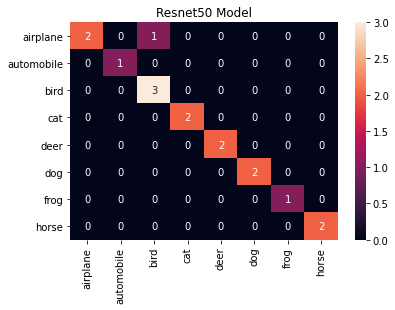

In [187]:
import pandas
import seaborn as sns

classes = [i for i in dataset.classes]
target = [i for i in dataset.classes]
df =  pd.DataFrame(conf_m, classes[:-2], target[:-2])
plt.title('Resnet50 Model')
sns.heatmap(df, annot=True)